## **Introduction**

Dans mon projet, j’ai développé un système de détection des émotions dans les textes, aussi bien en français qu’en anglais, en utilisant DistilBERT, une version allégée et optimisée de BERT. Mon objectif était de prédire les émotions exprimées dans un texte, comme la joie, la tristesse, la colère ou la peur, peu importe la langue. Pour cela, j’ai adapté et entraîné DistilBERT afin qu’il puisse analyser des textes en français et en anglais avec efficacité. Ce projet offre ainsi une solution multilingue performante, utile dans des contextes où l’analyse d’émotions dans plusieurs langues est nécessaire.

In [2]:


import time
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from plot_keras_history import show_history, plot_history
from tqdm import tqdm



e:\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\maben\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\maben\AppData\Roaming\Python

In [3]:
# Version of the libraries used
print('\n'.join(f'{m.__name__} - {m.__version__}'
                for m in globals().values()
                if getattr(m, '__version__', None)))

tensorflow - 2.18.0
numpy - 2.0.2
pandas - 2.2.3
torch - 2.0.1+cu117


---

### **Emotions Labels :**
- 0 : Sadness
- 1 : Joy 
- 2 : Love
- 3 : Anger
- 4 : Fear
- 5 : Surprise

1. Chargement des données :

In [4]:
#Chargement de l'ensemble de données
df = pd.read_csv('text.csv')

In [5]:
df.head(10)

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4
5,5,i was beginning to feel quite disheartened,0
6,6,i would think that whomever would be lucky eno...,2
7,7,i fear that they won t ever feel that deliciou...,1
8,8,im forever taking some time out to have a lie ...,5
9,9,i can still lose the weight without feeling de...,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  416809 non-null  int64 
 1   text        416809 non-null  object
 2   label       416809 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.5+ MB


In [7]:
df.isna().count()


Unnamed: 0    416809
text          416809
label         416809
dtype: int64

2. Préparation des données :

In [8]:
df = df.drop("Unnamed: 0", axis=1)
df

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3


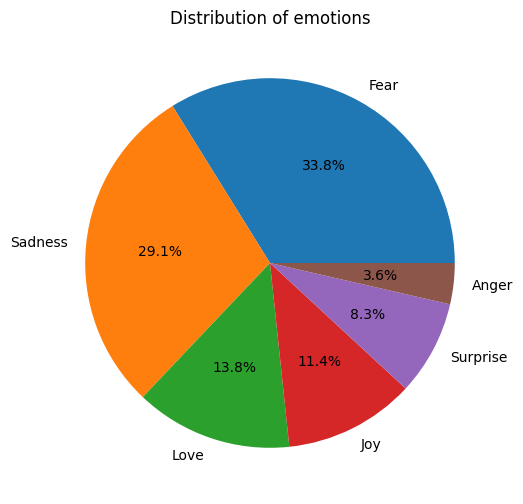

In [10]:
# Création d'un dictionnaire pour faire correspondre les numéros aux noms des émotions
emotion_dict = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}

# Remplacement des numéros par des noms d'émotions dans les étiquettes
labels = df['label'].replace(emotion_dict)

# Création d'un diagramme circulaire pour visualiser la distribution des émotions dans l'ensemble de données
plt.figure(figsize=(8,6))
plt.pie(labels.value_counts(), labels=labels.unique(), autopct='%1.1f%%')
plt.title('Distribution of emotions')
plt.show()

Nous constatons que la colonne des étiquettes, qui est notre cible, est déséquilibrée. Nous allons donc utiliser une redistribution des poids pour rééquilibrer l'importance des étiquettes dans l'ensemble de données.

In [11]:
# Initialisation des DataFrames pour l'entraînement, la validation et le test
train_df = pd.DataFrame()
validation_df = pd.DataFrame()
test_df = pd.DataFrame()

# Pour chaque classe, recueillir des échantillons pour la formation, la validation et le test.
for label in df['label'].unique():
    class_df = df[df['label'] == label]
    
    train_class_df = class_df.sample(n=5000, random_state=1)
    remaining_class_df = class_df.drop(train_class_df.index)
    
    validation_class_df = remaining_class_df.sample(n=1000, random_state=1)
    remaining_class_df = remaining_class_df.drop(validation_class_df.index)
    
    test_class_df = remaining_class_df.sample(n=1000, random_state=1)
    
    train_df = pd.concat([train_df, train_class_df])
    validation_df = pd.concat([validation_df, validation_class_df])
    test_df = pd.concat([test_df, test_class_df])

# Préparation des données d'apprentissage
train_texts, train_labels = train_df['text'], train_df['label']


# Préparation des données de validation
validation_texts, validation_labels = validation_df['text'], validation_df['label']

# Préparation des données de test
test_texts, test_labels = test_df['text'], test_df['label']

# Imprimer le nombre d'échantillons par classe pour chaque ensemble de données
print("Total number of samples per class:")
print("Training :")
print(train_df['label'].value_counts())
print("Validation :")
print(validation_df['label'].value_counts())
print("Test :")
print(test_df['label'].value_counts())

Total number of samples per class:
Training :
label
4    5000
0    5000
2    5000
1    5000
5    5000
3    5000
Name: count, dtype: int64
Validation :
label
4    1000
0    1000
2    1000
1    1000
5    1000
3    1000
Name: count, dtype: int64
Test :
label
4    1000
0    1000
2    1000
1    1000
5    1000
3    1000
Name: count, dtype: int64


Comme la plus petite classe ne compte que 15 000 échantillons (3,6 %), nous pouvons alors prélever au hasard 1 000 échantillons pour chaque classe afin de rééquilibrer l'ensemble de données.

---

## **DistilBert**

DistilBERT est une version allégée et optimisée de BERT (Bidirectional Encoder Representations from Transformers), développée dans le but de réduire la taille du modèle tout en maintenant des performances proches de l'original. Il est environ 60 % plus léger et plus rapide que BERT, tout en conservant 97 % de sa performance sur de nombreuses tâches de traitement du langage naturel (NLP). DistilBERT est obtenu grâce à une technique appelée distillation des connaissances, qui consiste à entraîner un modèle plus petit (DistilBERT) pour reproduire le comportement d’un modèle plus grand (BERT). Cela le rend idéal pour des applications nécessitant rapidité et efficacité, notamment sur des ressources matérielles limitées.

In [12]:
# Chargement du modèle DistilBERT
distil_bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distil_bert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=6) # 6 classes of emotions

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Déplacer le modèle vers le GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
distil_bert_model = distil_bert_model.to(device)
print(device)

cuda


In [15]:
# Préparation des données de l'entrainement
train_encodings = distil_bert_tokenizer(train_texts.tolist(), truncation=True, padding=True, return_tensors='pt')
train_labels = torch.tensor(train_labels.tolist())
train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, train_labels)

# Préparation des données de validation
validation_encodings = distil_bert_tokenizer(validation_texts.tolist(), truncation=True, padding=True, return_tensors='pt')
validation_labels = torch.tensor(validation_labels.tolist())
validation_dataset = TensorDataset(validation_encodings.input_ids, validation_encodings.attention_mask, validation_labels)

# Preparation des données de test
test_encodings = distil_bert_tokenizer(test_texts.tolist(), truncation=True, padding=True, return_tensors='pt')
test_labels = torch.tensor(test_labels.tolist())
test_dataset = TensorDataset(test_encodings.input_ids, test_encodings.attention_mask, test_labels)

In [16]:
# Définition de l'optimiseur, de la fonction de perte et des métriques
lr = 5e-5
optimizer = torch.optim.Adam(distil_bert_model.parameters(), lr=lr)
loss = torch.nn.CrossEntropyLoss()
metrics = ['accuracy']

# Modèle de compilation
epochs = 10
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
# Démarrer mod et la meilleure précision
history = {
    'train_loss': [],
    'validation_loss': [],
    'validation_accuracy': []
}
best_acc = 0.0

# Définir la force de régularisation pour la pénalité (éviter l'ajustement excessif)
l2_lambda = 0.001

start_time = time.time()
for epoch in range(epochs):
    # Entrainement
    distil_bert_model.train()
    total_loss = 0
    train_loader_progress = tqdm(train_loader, desc='Training')
    for batch in train_loader_progress:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch

        
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = distil_bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        #Ajouter L2 regularization
        l2_norm = sum(p.pow(2.0).sum() for p in distil_bert_model.parameters())
        loss = loss + l2_lambda * l2_norm

        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_loader_progress.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    avg_train_loss = total_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)

    # Validation
    distil_bert_model.eval()
    total_val_loss = 0
    total_correct = 0
    total_samples = 0
    validation_loader_progress = tqdm(validation_loader, desc='Validating')
    for batch in validation_loader_progress:
        input_ids, attention_mask, labels = batch

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = distil_bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_val_loss += loss.item()

        _, predictions = torch.max(outputs.logits, dim=1)
        correct = (predictions == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)

    avg_val_loss = total_val_loss / len(validation_loader)
    val_accuracy = total_correct / total_samples
    history['validation_loss'].append(avg_val_loss)
    history['validation_accuracy'].append(val_accuracy)

    print(f"Epoch: {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Save the best weigths
    if val_accuracy > best_acc:
        best_acc = val_accuracy
        if not os.path.exists('Poids'):
            os.makedirs('Poids')
        torch.save(distil_bert_model.state_dict(), 'Poids/en_best_distilbert.pth')

end_time = time.time()

Validating: 100%|██████████| 188/188 [00:14<00:00, 13.11it/s]


Epoch: 1, Training Loss: 50.6251, Validation Loss: 0.1415, Validation Accuracy: 0.9495


Validating: 100%|██████████| 188/188 [00:14<00:00, 13.07it/s]


Epoch: 2, Training Loss: 25.8171, Validation Loss: 0.1482, Validation Accuracy: 0.9455


Validating: 100%|██████████| 188/188 [00:14<00:00, 13.06it/s]


Epoch: 3, Training Loss: 15.1979, Validation Loss: 0.1599, Validation Accuracy: 0.9388


Validating: 100%|██████████| 188/188 [00:14<00:00, 13.03it/s]


Epoch: 4, Training Loss: 10.2888, Validation Loss: 0.1513, Validation Accuracy: 0.9442


Validating: 100%|██████████| 188/188 [00:15<00:00, 12.50it/s]


Epoch: 5, Training Loss: 7.7145, Validation Loss: 0.1561, Validation Accuracy: 0.9448


Validating: 100%|██████████| 188/188 [00:13<00:00, 13.50it/s]


Epoch: 6, Training Loss: 6.1783, Validation Loss: 0.1530, Validation Accuracy: 0.9465


Validating: 100%|██████████| 188/188 [00:13<00:00, 13.70it/s]


Epoch: 7, Training Loss: 5.1552, Validation Loss: 0.1527, Validation Accuracy: 0.9458


Validating: 100%|██████████| 188/188 [00:13<00:00, 13.68it/s]


Epoch: 8, Training Loss: 4.4202, Validation Loss: 0.1586, Validation Accuracy: 0.9432


Validating: 100%|██████████| 188/188 [00:14<00:00, 13.09it/s]


Epoch: 9, Training Loss: 3.8535, Validation Loss: 0.1753, Validation Accuracy: 0.9448


Validating: 100%|██████████| 188/188 [00:13<00:00, 13.67it/s]

Epoch: 10, Training Loss: 3.3927, Validation Loss: 0.1765, Validation Accuracy: 0.9348


In [19]:
time_train_distilbert = end_time - start_time
print(f"Training Time --> {time_train_distilbert/60}")

Training Time --> 57.618533019224806


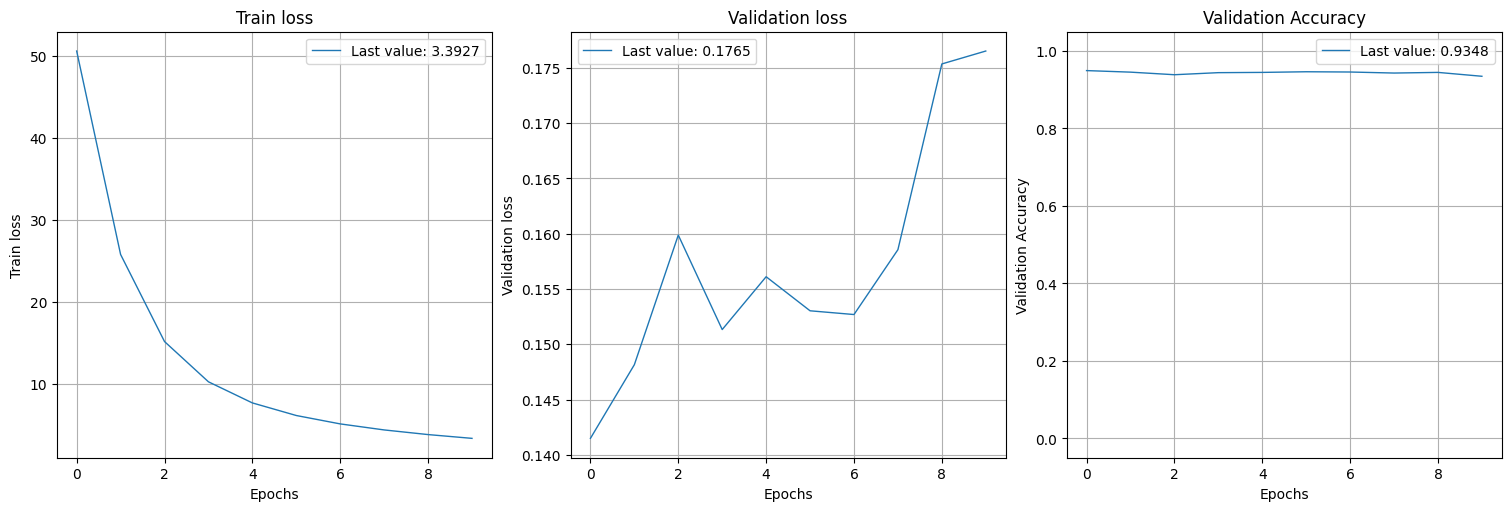

In [20]:
show_history(history)
plot_history(history, path="../history/en_distilbert_training.png")
plt.close()

---

In [35]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distil_bert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=6)
distil_bert_model.load_state_dict(torch.load('../weigths/en_best_distilbert.pth'))

# Move the model to the GPU
distil_bert_model = distil_bert_model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Evaluation
distil_bert_model.eval()
total_test_loss = 0
total_correct = 0
total_samples = 0
test_loader_progress = tqdm(test_loader, desc='Testing')
for batch in test_loader_progress:
    input_ids, attention_mask, labels = batch

    # Move data to GPU
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = distil_bert_model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    total_test_loss += loss.item()

    # Accuracy calculation
    _, predictions = torch.max(outputs.logits, dim=1)
    correct = (predictions == labels).sum().item()
    total_correct += correct
    total_samples += labels.size(0)

avg_test_loss = total_test_loss / len(test_loader)
test_accuracy = total_correct / total_samples

print(f"Test Loss: {avg_test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")

Testing: 100%|██████████| 188/188 [00:17<00:00, 11.02it/s]

Test Loss: 0.19, Test Accuracy: 0.93


---